# Geostatistics

Spatial statistics is a branch of statistics that deals with the analysis and interpretation of data that has spatial or geographical components, considering how neighboring locations influence each other. It involves techniques for exploring, modelling, and understanding the patterns and relationships within spatial data.

## Three types of spatial data

There is three types of spatial data - areal, geostatistical, and point pattern. 


Selection of the spatial statistical method is determined by the type of the available information about the data. There are three types of spatial data and corresponding models: point-level (or <font color='orange'>geostatistical</font> data, <font color='orange'>areal</font> (or lattice) data and spatial <font color='orange'>point patterns</font>. 

<span style="color:orange">Geostatistical data</span> is a collection of  <font color='orange'>random observations</font> at <font color='orange'>fixed locations</font>. Spatial proximity is defined via a function of distance between pairs of locations.The goal of geostatistical modelling is to identify the effect of covariates that determine disease risk and to predict the outcome at unsampled locations within the study area (referred to as <font color='orange'>kriging</font>). 

<font color='orange'>Areal data</font> are individual-level or aggregated data typically consisting of counts or rates with geographical information available over a set of regions with common borders. These areas may correspond to administrative units such as states, districts or counties or a regular grid - lattice. Spatial correlation between areas is implemented based on the neighbouring structure. Analysis of areal data aims to identify trends and spatial patterns and to assess large-scale associations between the disease risk and its predictors. 

<span style="color:orange">Point pattern</span> data consists of random locations of events. Dependence between case locations is modelled via a Gaussian process. This type of models are particularly appealing for datasets with precisely known locations of events due to their ability to capture disease clusters and identify factors associated with them. Events of a point pattern, tagged with an additional discrete coordinate, constitute <font color='orange'>marked point pattern</font> data. 


## Geostatistics and kriging

Geostatistics is the subarea of spatial statstistics which works with geostatstitical data. It finds applications in various fields such as natural resource exploration (e.g., oil and gas reserves estimation), environmental monitoring (e.g., air and water quality assessment), agriculture (e.g., soil fertility mapping), and urban planning (e.g., land use analysis) and, of course, epidemiology (e.g., disease mapping). It offers powerful tools for spatial data analysis, decision-making, and resource management in both scientific research and practical applications.

 <span style="color:orange">Kriging</span> is a statistical interpolation technique used primarily in geostatistics. It is named after South African mining engineer DanielG. Krige, who developed the method in the 1950s. Kriging is employed to estimate the value of a variable at an <span style="color:orange">unmeasured location</span>based on the values <span style="color:orange">observed</span> at nearby locations.

The basic idea behind kriging is to model the spatial correlation or spatial autocorrelation of the variable being studied. This means that kriging considers the spatial structure of the data. It assumes that nearby points are more similar than those farther away and uses this information to make predictions.

Kriging provides not only the  <span style="color:orange">predicted value</span> at an unmeasured location but also an estimate of the <span style="color:orange">uncertainty</span> associated with that prediction. This is valuable because it allows users to assess the reliability of the interpolated values.

As you might have guessed, kriging can be performed using Gaussian Processes! GPs are appropriate for kriging due to their flexibility in modeling complex spatial correlations, ability to quantify uncertainty and flexibility in kernel selection; i.e. GPs tick all the boxes required for kriging.


In [1]:
import pickle

import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import init_to_median, Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)  # Set the device count to enable parallel sampling

/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Kriging: synthetic visualisation in 2d 

Let us visualise schematically how kriging looks like.

In [2]:
# Generate synthetic data
np.random.seed(0)

x_train = np.random.uniform(0, 10, (10, 2))              # Training points - x
y_train = np.sin(x_train[:, 0]) * np.cos(x_train[:, 1])  # Training targets - y

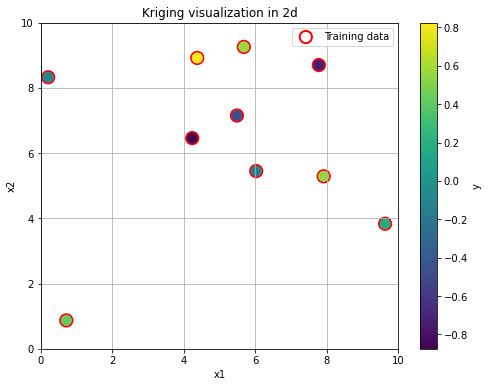

In [3]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], s=150, c='none', edgecolor='red', linewidth=2, label='Training data')
plt.scatter(x_train[:, 0], x_train[:, 1], s=100, c=y_train, cmap='viridis')
plt.title('Kriging visualization in 2d')
plt.colorbar(label='y')
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


Our goal now is, given these points, to reconstruct the entire continuous surface over the region $(0,10) \times (0,10)$ assuming the GP model. Let's do it in a non-Bayesian way first, for illustrative purpuses.

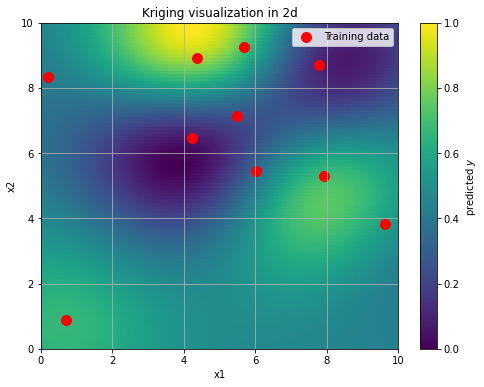

In [4]:
# Generate grid points for visualization
x_min, x_max = 0, 10
y_min, y_max = 0, 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
x_grid = np.c_[xx.ravel(), yy.ravel()]  # 2D grid points

# fit Gaussian process model
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)
gp.fit(x_train, y_train)

# Predict values for grid points
y_pred, sigma = gp.predict(x_grid, return_std=True)

# Plot the results
plt.figure(figsize=(8, 6))
#plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap='viridis')
plt.scatter(xx, yy, s=100, c=y_pred.reshape(xx.shape), cmap='viridis')
plt.scatter(x_train[:, 0], x_train[:, 1], color='red', label='Training data', s=100)
plt.colorbar(label='predicted $y$')
plt.title('Kriging visualization in 2d')
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

The command above `GaussianProcessRegressor` worked out very well. However, if we want to work with non-Gaussian likelihoods, and more complex models overall, such striaghtforward tools won't be available to us. Hence, we need to understand now to implement such models in Numpyro.

## 1d example

### Generate data

In [5]:
# synthetic data
n_points = 50
x = np.linspace(0, 2*np.pi, n_points)
f_true = np.sin(x)

# noisy observations
y_true = f_true + np.random.normal(0, 0.2, size=n_points)

# inidices to skip (and where to make predictions)
skip_idx = np.array([4, 5, 10, 15, 20, 21, 22,  25, 30, 35,36, 38, 40, 45])

# indices of observed locations excluding skip_idx
obs_idx = np.delete(np.arange(n_points), skip_idx)
y_obs = y_true[obs_idx]

### Visualise

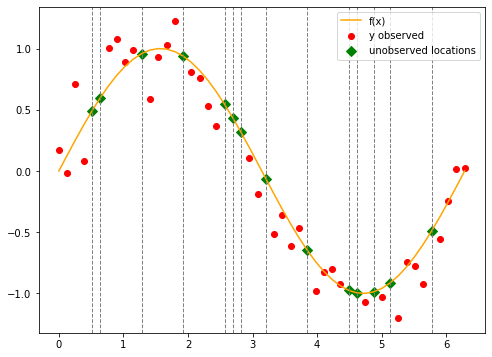

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x[obs_idx], y_obs, color='red', label='y observed')

# unobserved locations
plt.scatter(x[skip_idx], f_true[skip_idx], color='green', label='unobserved locations', s=50, marker='D')

for idx in skip_idx:
    plt.axvline(x=x[idx], color='gray', linestyle='--', linewidth=1)

plt.legend(loc='upper right')
plt.show()


### Infer

```{margin}
You might have noticed - this is the exact same kernel and code as in the previous notebook, i.e. we are being repetitive. The code is redundant but the aim is for each notebook to be self-sufficient.
```

In [7]:
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

In [8]:
def model(x, obs_idx, y_obs=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
      
    numpyro.sample("y", dist.Normal(f[obs_idx], sigma), obs=y_obs)

In [9]:
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), jnp.array(x), jnp.array(obs_idx), jnp.array(y_obs))

### Diagnose


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.04      0.13     -0.04     -0.25      0.18   3979.83      1.00
      f[1]      0.07      0.11      0.07     -0.10      0.25   3566.61      1.00
      f[2]      0.20      0.09      0.20      0.05      0.35   3293.72      1.00
      f[3]      0.33      0.09      0.32      0.18      0.47   3178.84      1.00
      f[4]      0.46      0.09      0.46      0.31      0.60   3154.44      1.00
      f[5]      0.58      0.09      0.58      0.44      0.73   3141.05      1.00
      f[6]      0.71      0.09      0.71      0.56      0.84   3114.71      1.00
      f[7]      0.82      0.08      0.82      0.68      0.96   3066.47      1.00
      f[8]      0.92      0.08      0.92      0.78      1.05   3008.90      1.00
      f[9]      1.01      0.08      1.01      0.87      1.13   2941.45      1.00
     f[10]      1.07      0.08      1.07      0.94      1.20   2890.57      1.00
     f[11]      1.12      0

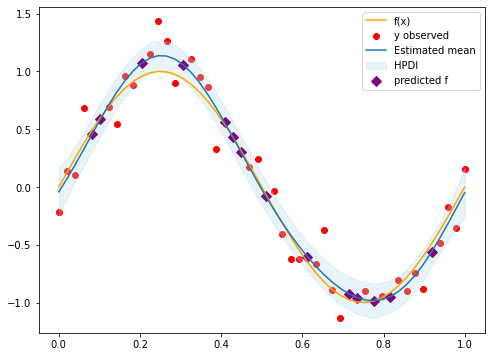

In [ ]:
mcmc.print_summary()

posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']

f_mean = jnp.mean(f_posterior, axis=0)
f_hpdi = hpdi(f_posterior, 0.90)

plt.figure(figsize=(8, 6))
plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x[obs_idx], y_obs, color='red', label='y observed')

plt.plot(x, f_mean, label='Estimated mean')
plt.fill_between(x.squeeze(), f_hpdi[0], f_hpdi[1], color='lightblue', alpha=0.3, label='HPDI')  # Uncertainty bounds
plt.scatter(x[skip_idx], f_mean[skip_idx], color='purple', label='predicted f', s=50, marker='D')

plt.legend()
plt.show()


In [ ]:
xmin = np.min([np.min(f_true), np.min(f_mean)])
xmax = np.max([np.max(f_true), np.max(f_mean)])

ymin = xmin
ymax = xmax

plt.figure(figsize=(4, 4))

# Plot observed data
plt.plot(f_true[skip_idx], f_mean[skip_idx], 'o', label='Obtained results')

# Plot diagonal line
plt.plot([xmin, xmax], [ymin, ymax], color='red', linestyle='--', label='Ideal prediction')

plt.xlabel('True $f$ at unobserved locations')
plt.ylabel('Predicted $f$ at unobserved locations')

plt.xlim(xmin, xmax) 
plt.ylim(ymin, ymax)  

plt.title('Comparison of True and Predicted $f$')

plt.legend()

plt.grid(True)
plt.show()


TypeError: Using a non-tuple sequence for multidimensional indexing is not allowed; use `arr[tuple(seq)]` instead of `arr[seq]`. See https://github.com/google/jax/issues/4564 for more information.

<Figure size 288x288 with 0 Axes>

## 2d example

### Generate data

In [ ]:
n_points_x = 10
n_points_y = 8

x = jnp.linspace(0, 2*jnp.pi, n_points_x)
y = jnp.linspace(0, 2*jnp.pi, n_points_y)
xx, yy = jnp.meshgrid(x, y)
x_2d = jnp.column_stack([xx.ravel(), yy.ravel()])

skip_idx = [(0, 1), (2, 4), (3, 1), (5,6)]

obs_idx = np.delete(np.arange(n_points_x * n_points_y), [i * n_points_x + j for i, j in skip_idx])

f_true = jnp.sin(xx/1.2) * jnp.cos(yy)
noise = np.random.normal(0, 0.1, size=(n_points_y, n_points_x))

y_true = (f_true + noise)

### Visualise

<ipython-input-67-cff4261d7919>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='red')
<ipython-input-67-cff4261d7919>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


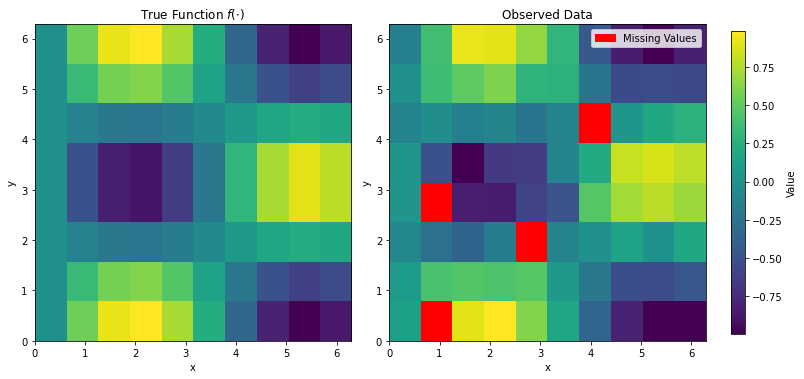

In [ ]:
cmap = plt.cm.viridis
cmap.set_bad(color='red')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

im1 = axes[0].imshow(f_true, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
axes[0].set_title('True Function $f(\cdot)$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

masked_data = np.ma.masked_where(np.zeros_like(y_true, dtype=bool), y_true)
for idx in skip_idx:
    masked_data[idx] = np.ma.masked

im2 = axes[1].imshow(masked_data, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap) 
axes[1].set_title('Observed Data')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

legend_handles = [mpatches.Patch(color='red', label='Missing Values')]
axes[1].legend(handles=legend_handles)

cax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

### Infer

```{margin}
Note: we are using here exactly same code for the `rbf_kernel` and `model` as we did in the one-dimensional case! This is all possible because GP only needs pair-wise distances between locations, which we can compute agnostically in any dimension.
```

In [ ]:
y_true_flat = y_true.ravel()
y_obs = y_true_flat[obs_idx] 

print(y_true.shape)
print(y_true.shape)

# check the shapes
print(x_2d.shape)
print(obs_idx.shape)
print(y_obs.shape)

(8, 10)
(8, 10)
(80, 2)
(76,)
(76,)


In [ ]:
# ATTENTION: this cell might take a while to run

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), jnp.array(x_2d), jnp.array(obs_idx), jnp.array(y_obs))

In [ ]:
# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']

# Calculate mean and standard deviation
f_mean = jnp.mean(f_posterior, axis=0)
f_std = jnp.std(f_posterior, axis=0)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.15      0.15      0.15     -0.10      0.39  32584.83      1.00
      f[1]      0.00      1.01      0.00     -1.59      1.70   6907.62      1.00
      f[2]      0.94      0.16      0.95      0.69      1.19  11258.85      1.00
      f[3]      1.03      0.16      1.04      0.78      1.28  10690.39      1.00
      f[4]      0.65      0.15      0.66      0.40      0.90  25035.72      1.00
      f[5]      0.19      0.15      0.19     -0.07      0.43  32985.96      1.00
      f[6]     -0.35      0.15     -0.35     -0.59     -0.11  29510.27      1.00
      f[7]     -0.81      0.15     -0.82     -1.05     -0.56  14717.12      1.00
      f[8]     -1.01      0.15     -1.02     -1.24     -0.75  11261.67      1.00
      f[9]     -1.01      0.16     -1.03     -1.25     -0.75  10566.52      1.00
     f[10]      0.11      0.15      0.11     -0.14      0.34  36135.02      1.00
     f[11]      0.44      0

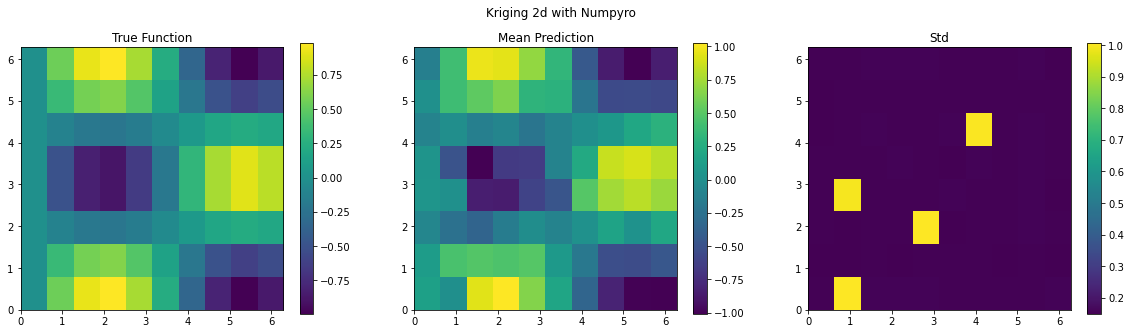

In [ ]:
f_mean_2d = f_mean.reshape(xx.shape)
f_std_2d  = f_std.reshape(xx.shape)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.imshow(f_true, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('True Function')

plt.subplot(1, 3, 2)
plt.imshow(f_mean_2d, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Mean Prediction')

plt.subplot(1, 3, 3)
plt.imshow(f_std_2d, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Std')

plt.suptitle('Kriging 2d with Numpyro')
plt.show()

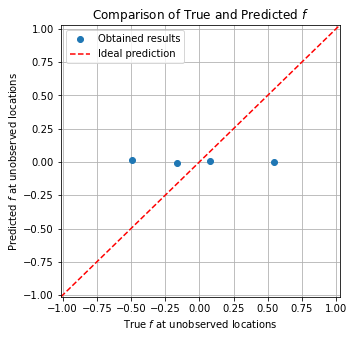

In [ ]:
f_true_flat = f_true.flatten()
xmin = np.min([np.min(f_true_flat), np.min(f_mean)])
xmax = np.max([np.max(f_true_flat), np.max(f_mean)])
ymin = xmin
ymax = xmax

plt.figure(figsize=(4, 4))  
skip_idx_1d = np.array([i * n_points_x + j for i, j in skip_idx])
plt.plot(f_true_flat[skip_idx_1d], f_mean[skip_idx_1d], 'o', label='Obtained results')
plt.plot([xmin, xmax], [ymin, ymax], color='red', linestyle='--', label='Ideal prediction')
plt.xlabel('True $f$ at unobserved locations')
plt.ylabel('Predicted $f$ at unobserved locations')
plt.xlim(xmin, xmax)  
plt.ylim(ymin, ymax)  
plt.title('Comparison of True and Predicted $f$')
plt.legend()
plt.grid(True)
plt.show()

`````{admonition} Group Task 
:class: tip

It does not look like the model has done a good job estimating unobserved values.

What could have gone wrong?

`````

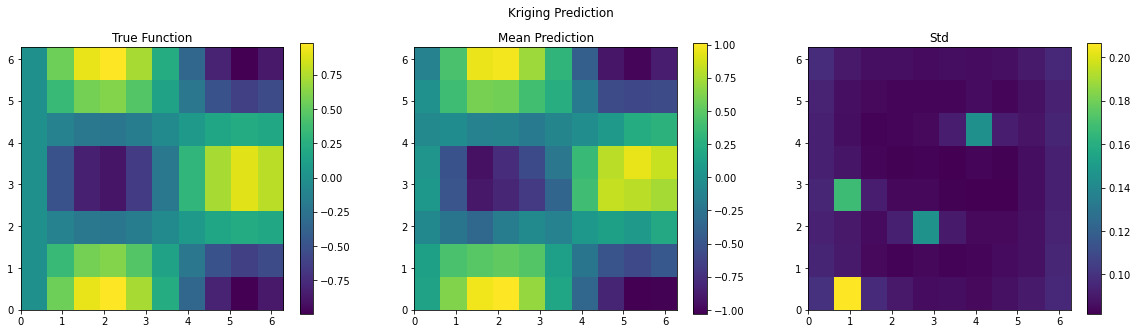

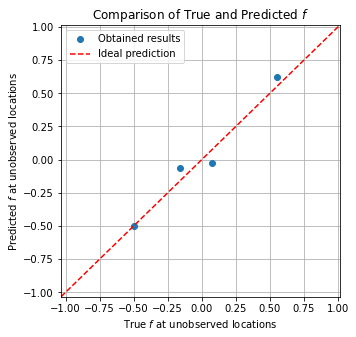

In [ ]:
# ATTENTION: this cell might take a while to run

# fit the model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), jnp.array(x_2d), jnp.array(obs_idx), jnp.array(y_obs), kernel_func=rbf_kernel, lengthcsale=1.0)

# exatrct posterior
posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']

f_mean = jnp.mean(f_posterior, axis=0)
f_std = jnp.std(f_posterior, axis=0)

f_mean_2d = f_mean.reshape(xx.shape)
f_std_2d  = f_std.reshape(xx.shape)

# plot results
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(f_true, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('True Function')

plt.subplot(1, 3, 2)
plt.imshow(f_mean_2d, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Mean Prediction')

plt.subplot(1, 3, 3)
plt.imshow(f_std_2d, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Std')

plt.suptitle('Kriging Prediction')
plt.show()

# plot results
xmin = np.min([np.min(f_true_flat), np.min(f_mean)])
xmax = np.max([np.max(f_true_flat), np.max(f_mean)])
ymin = xmin
ymax = xmax
plt.figure(figsize=(5, 5)) 
plt.plot(f_true_flat[skip_idx_1d], f_mean[skip_idx_1d], 'o', label='Obtained results')
plt.plot([xmin, xmax], [ymin, ymax], color='red', linestyle='--', label='Ideal prediction')
plt.xlabel('True $f$ at unobserved locations')
plt.ylabel('Predicted $f$ at unobserved locations')
plt.xlim(xmin, xmax)  
plt.ylim(ymin, ymax) 
plt.title('Comparison of True and Predicted $f$')
plt.legend()
plt.grid(True)
plt.show()